# Introduction


In this notebook, is presented a PyTorch re-implementation of the paper "**MATFORMER: NESTED TRANSFORMER FOR ELASTIC INFERENCE.**" The paper introduces MatFormer, a nested Transformer architecture designed to provide elasticity under various deployment constraints. Since Transformer models are deployed in a wide range of environments, models of different sizes are often required. With MatFormer, it is possible to train a single model and extract multiple smaller models from it, tailored to different resource limitations.



Link to the article: (https://arxiv.org/abs/2310.07707)


**Student:** *Di Nepi Gavriel 2066753*

# Imports

In [1]:
# install dependecies
!pip install sentencepiece
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm
from datasets import load_dataset
import pandas as pd
import plotly.express as px
import time
import os
import numpy as np
import random


In [3]:
#set the seed to reproduce the experiments
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Network and useful functions

In [4]:
def create_key_padding_mask(sequence,pad_token=4):
  #Create a key padding mask for a sequence with True and False (True = pad_token, False = token)
  padding_positions = (sequence == pad_token)
  return padding_positions

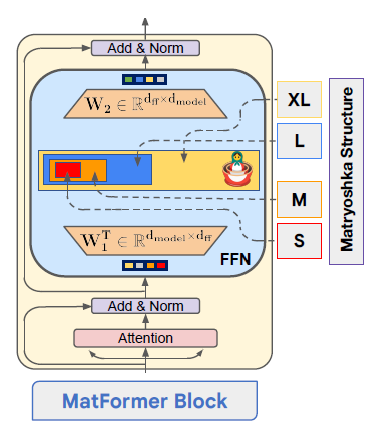

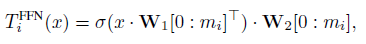

MatLM consists of ***l  layers*** of MatFormer Blocks. The Feed Forward Network (FFN) within each block follows a Matryoshka structure, where the maximum number of neurons corresponds to d_ffn, and the network is divided into 4 levels of granularity. Neurons from the smaller granularities are shared with the larger ones. This sharing of neurons, combined with the joint loss computation across different granularities, encourages the model to utilize the first m_i neurons in a more significant way.


For the rest of the network I used the normal decoder structure:
 - Embeddings
 - Positional Embeddings
 - l layers of MatFormer Block
 - Normalization layer
 - Linear layer

The multi-head attention mechanism can be used with or without a mask.

- For pre-training, I used a causal mask to prevent the model from attending to future tokens, ensuring that each token only attends to previous ones.
- For fine-tuning, since the sequences had varying lengths, I applied a padding mask to ignore the padded tokens and ensure that the attention mechanism only focuses on the actual sequence data.

In [5]:
class NestedFFN(nn.Module):
    def __init__(self, d_model, d_ffn):
        super(NestedFFN, self).__init__()
        self.d_model = d_model
        self.d_ffn = d_ffn

        # Shared layer
        self.W1 = nn.Linear(d_model, d_ffn)
        self.W2 = nn.Linear(d_ffn, d_model)

        # Activation function
        self.activation = nn.GELU()

    def forward(self, x, level):
        # Number of neurons for each layer
        if level == 1:
            m_i = self.d_ffn // 8
        elif level == 2:
            m_i = self.d_ffn // 4
        elif level == 3:
            m_i = self.d_ffn // 2
        elif level == 4:
            m_i = self.d_ffn
        else:
            raise ValueError("The number of level must be less or equal than 4")

        # Using only the first m_i neurons
        W1_weight = self.W1.weight[:m_i, :]
        W1_bias = self.W1.bias[:m_i] if self.W1.bias is not None else None
        hidden = self.activation(F.linear(x, W1_weight, W1_bias))

        W2_weight = self.W2.weight[:, :m_i]
        W2_bias = self.W2.bias if self.W2.bias is not None else None
        output = F.linear(hidden, W2_weight, W2_bias)

        return output


class MatFormerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ffn,type_mask=True):
        super(MatFormerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)
        self.num_heads=n_heads
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = NestedFFN(d_model, d_ffn)
        self.type_mask=type_mask

    def forward(self, x, level,input_seq):

        x = x.transpose(0, 1)
        if self.type_mask=='causal':
          causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(0)).to(x.device)
          attn_output, _ = self.self_attn(x,x,x,attn_mask=causal_mask,is_causal=True)
        elif self.type_mask=='pad':
          mask=create_key_padding_mask(input_seq).to(x.device)
          attn_output, _ = self.self_attn(x, x, x,key_padding_mask=mask,is_causal=False)
        else :
          attn_output, _ = self.self_attn(x, x, x,is_causal=False)

        x = x + attn_output  # Residual connection
        x = self.norm1(x)

        # FFN with the specif granularity
        ffn_output = self.ffn(x, level)
        x = x + ffn_output  # Residual connection
        x = self.norm2(x)
        x = x.transpose(0, 1)

        return x


class PositionalEncoding(nn.Module):
  # written using chatGPT
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0).transpose(0, 1)

    def forward(self, x):

        pe = self.pe[:x.size(0), :].to(x.device)
        return x + pe


class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ffn,type_mask=True):
        super(Block, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)
        self.num_heads=n_heads
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Linear(d_model, d_ffn)
        self.activation = nn.GELU()
        self.ffn2 = nn.Linear(d_ffn,d_model)
        self.type_mask=type_mask

    def forward(self, x,input_seq):

        x = x.transpose(0, 1)
        if self.type_mask=='causal':
          causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(0)).to(x.device)
          attn_output, _ = self.self_attn(x,x,x,attn_mask=causal_mask,is_causal=True)
        elif self.type_mask=='pad':
          mask=create_key_padding_mask(input_seq).to(x.device)
          attn_output, _ = self.self_attn(x, x, x,key_padding_mask=mask,is_causal=False)
        else :
          attn_output, _ = self.self_attn(x, x, x,is_causal=False)

        x = x + attn_output  # Residual connection
        x = self.norm1(x)

        # FFN with the specif granularity
        ffn_output = self.activation(self.ffn(x))
        ffn_output = self.ffn2(ffn_output)
        x = x + ffn_output  # Residual connection
        x = self.norm2(x)
        x = x.transpose(0, 1)

        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ffn, num_layers, max_len,need_mask,use_MatForm):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.use_MatForm = use_MatForm
        if use_MatForm:
          self.layers = nn.ModuleList([MatFormerBlock(d_model, n_heads, d_ffn,need_mask) for _ in range(num_layers)])
        else:
          self.layers = nn.ModuleList([Block(d_model, n_heads, d_ffn,need_mask) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.last_layer_dim = vocab_size

    def forward(self, x, level=-1):
        input_seq= x.clone()
        # balance the scale among embeddings and positional encodings
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.embedding.embedding_dim, dtype=torch.float))
        x = self.positional_encoding(x)
        if self.use_MatForm:
          for layer in self.layers:
            x = layer(x, level,input_seq)
        else:
          for layer in self.layers:
            x = layer(x,input_seq)
        x = self.norm(x)
        x = self.fc_out(x)

        return x

The loss is defined at the joint Loss among all the levels, all with the same weigth. Like the article I decided to use 4 (S,M,L,XL) levels each with the following number of hidden neurons.

S = d_model /2

M = d_model

L = d_model * 2

XL = d_model * 4

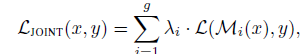

In [6]:
def compute_joint_loss(model, x, target, criterion, levels=[1, 2, 3, 4], weights=[0.25, 0.25, 0.25, 0.25]):
    total_loss = 0

    for i, level in enumerate(levels):
        output = model(x, level)
        loss = criterion(output.view(-1, output.size(-1)), target.view(-1))
        total_loss += weights[i] * loss
    return total_loss

# Tokenizer: Sentencepiece

I used the same tokenizer specified in the article SentencePiece, to train it I had to use a corpus of text so I decided to use wikitext

In [7]:
# Download WikiText-103 dataset
dataset = load_dataset("wikitext", "wikitext-103-v1")
train_text = dataset['train']['text']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [8]:
# example of data structure
train_text[:4]

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n']

In [9]:
# Since data contains some variables tha we are not interested in we remove these entries
filtered_text = [line for line in train_text if not line.startswith(' =') and line.strip() != '']

Having a limited resource I could use just a small part of the dataset

In [10]:
#the dataset is too large so we take just a partition
print(len(filtered_text))
small_filtered_text = filtered_text[:len(filtered_text)//1000]
print(len(small_filtered_text))

859532
859


In [11]:
validation_text = dataset['validation']['text']
validation_text = [line for line in validation_text if not line.startswith(' =') and line.strip() != '']
print(len(validation_text))
small_validation_text = validation_text[:len(validation_text)//20]
print(len(small_validation_text))


1841
92


In [12]:
test_text = dataset['test']['text']
test_text = [line for line in test_text if not line.startswith(' =') and line.strip() != '']
print(len(test_text))
small_test_text = test_text[:len(test_text)//20]
print(len(small_test_text))

2183
109


In [13]:
# To train the SentencePiece tokenizer we need a single text file, so we concatenate all entries in a single file
with open('train_wikitext_smaller.txt', 'w', encoding='utf-8') as f:
    for line in small_filtered_text:
        f.write(line + "\n")


In [14]:
# Parameters
vocab_size = 5000  # number of sub-words

In [15]:
# We train the tokenizer defining a pad and a sep token, used in the finetuning
spm.SentencePieceTrainer.train(input='train_wikitext_smaller.txt',
                               model_prefix='wikitext_spm',
                               vocab_size=vocab_size,
                               pad_id=4,
                               pad_piece="<pad>",
                               control_symbols=['[SEP]'],
                               )

In [16]:
# We define and load a SentencePiece and we see how it tokenizes the sentence
sp = spm.SentencePieceProcessor()
sp.load('wikitext_spm.model')

# Example
sample_sentence = "This is an example to see if everything works"
tokenized_sentence = sp.encode(sample_sentence, out_type=str)

print("Tokenized sentence:", tokenized_sentence)


Tokenized sentence: ['▁Thi', 's', '▁is', '▁an', '▁example', '▁to', '▁see', '▁', 'if', '▁every', 'thing', '▁work', 's']


As we can see, the tokenizer does not split the sentence correctly. Specifically, we notice that the word "This" has been split into two subwords: "_This" and "s." This due to the fact that we have a limited number of vocab and the text was too small

#Pretraining

### Functions

In [17]:
class TextDataset(Dataset):
    def __init__(self, text, tokenizer, block_size):
        self.tokenizer = tokenizer
        self.block_size = block_size
        # Tokenize the text
        tokenized_text = [tokenizer.encode(line, out_type=int) for line in text if len(line) > 0]

        self.token_ids=[]
        #since we don't want different sentence to be concatenated we add a split token
        for sublist in tokenized_text:
          if len(sublist) > self.block_size:
            self.token_ids.extend(sublist)
            self.token_ids.append(-1)

        #we build an index to obtain an element with no -1 inside
        self.valid_indexes = [i for i in range(len(self.token_ids) - self.block_size)
                              if -1 not in self.token_ids[i:i + self.block_size + 1]]

    def __len__(self):
        return len(self.valid_indexes)

    def __getitem__(self, idx):
        idx = self.valid_indexes[idx]
        # it creates a window of block_size dimension to predict the next token
        input_ids = self.token_ids[idx:idx + self.block_size]
        target_ids = self.token_ids[idx + 1: idx + self.block_size + 1]  # Target = next token
        return torch.tensor(input_ids), torch.tensor(target_ids)

Since we are trying to predict the next word, simply looking at the loss might not be enough to fully understand how well our model is performing. Therefore, I created a function that generates additional words based on a given input text.

In [18]:
def generate_text_simple(model, idx, max_new_tokens, context_size,level):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # take the contenxt_size of the entries
        idx_cond = idx[:, -context_size:].to("cuda")

        # Get the predictions
        with torch.no_grad():

            logits = model(idx_cond,level)

        # Focus only on the last time step
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        prob = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(prob, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [19]:
def generate_and_print_sample(model, device, start_context,level=-1):
    model.eval()
    context_size = model.last_layer_dim
    encoded = torch.tensor(sp.encode(start_context)).unsqueeze(0).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=32, context_size=context_size,level=level
        )
    decoded_text = sp.decode(token_ids[0].cpu().numpy().flatten().tolist())
    print(decoded_text.replace("\n", " "))

In [20]:
def plot_losses(training_losses, validation_losses):
  epochs = list(range(1, len(training_losses) + 1))

  data = pd.DataFrame({
      'Epoch': epochs,
      'Training Loss': training_losses,
      'Validation Loss': validation_losses
  })

  # Reshape the data for Plotly Express (to use a single 'Loss' column for both training and validation)
  df_melted = data.melt(id_vars='Epoch', value_vars=['Training Loss', 'Validation Loss'],
                        var_name='Loss Type', value_name='Loss')

  # Plot using Plotly Express
  fig = px.line(df_melted, x='Epoch', y='Loss', color='Loss Type',
                title='Training and Validation Loss Over Epochs',
                labels={'Loss': 'Loss Value', 'Epoch': 'Epoch Number'})

  # Show the figure
  fig.show()

In [21]:
def evaluate_model(model, data_loader, criterion, device,type_loss,use_MatForm=True):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for i, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if use_MatForm:
              loss = compute_joint_loss(model, inputs, targets, criterion)
            else:
              output = model(inputs)
              loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))

            total_loss += loss.item()
    avg_test_loss = total_loss / len(data_loader)
    print(f"{type_loss} Loss: {avg_test_loss:.4f}")

    print(f"Example of text generation")
    start_context = "it is commonly"
    if use_MatForm:
      for level in range(1, 5):
        print(f"Level {level}:")
        generate_and_print_sample(model, device, start_context, level)
    else:
      generate_and_print_sample(model, device, start_context)


    return avg_test_loss

In [ ]:
def evaluate_mat_single_level(model, data_loader, criterion, device,level):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for i, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs,level)
            loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))

            total_loss += loss.item()
    avg_test_loss = total_loss / len(data_loader)
    print(f"Level {level} - Loss: {avg_test_loss:.4f}")

    print(f"Example of text generation")
    start_context = "it is commonly"
    generate_and_print_sample(model, device, start_context, level)

    return avg_test_loss

For training, I used gradient accumulation as suggested in section B.1, since the available GPU memory only allowed a batch size of 32.


In [22]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=3, device="cuda",use_MatForm=True):
    model.to(device)

    model.eval()  # Switch to evaluation mode

    print(f"Pre-training - Example of text generation")
    start_context = "it is commonly"
    if use_MatForm:
      for level in range(1, 5):
          print(f"Level {level}:")
          generate_and_print_sample(model, device, start_context, level)
    else:
      generate_and_print_sample(model, device, start_context)


    accumulation_step = 4
    total_training_time = 0.0  # Initialize total training time

    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Switch to training mode
        running_loss = 0.0
        epoch_loss = 0.0

        optimizer.zero_grad()

        # Measure the start time for the epoch
        start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if use_MatForm:
              loss = compute_joint_loss(model, inputs, targets, criterion)
            else:
              output = model(inputs)
              loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))

            # Backward pass and weight update
            loss.backward()

            if (i + 1) % accumulation_step == 0:
                optimizer.step()
                optimizer.zero_grad()

            # Update running loss and total epoch loss
            running_loss += loss.item()
            epoch_loss += loss.item()

        # Measure the end time for the epoch
        end_time = time.time()

        # Calculate and print training time for the epoch
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time

        # Calculate and store the average training loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        print("")
        print(f"Epoch {epoch+1} completed. Average Training Loss: {avg_train_loss:.4f}")
        print(f"Training time for Epoch {epoch + 1}: {epoch_training_time:.2f} seconds")

        # Validation phase
        avg_val_loss = evaluate_model(model,validation_loader,criterion,device,"Validation",use_MatForm)
        validation_losses.append(avg_val_loss)



    # Print total training time excluding evaluation
    print(f"Total training time (excluding evaluation): {total_training_time:.2f} seconds")
    print("Training completed")

    # Return the lists of losses
    return training_losses, validation_losses, total_training_time

### Dataloader and parameters initialization

In [23]:
block_size = 64  # context dimension
batch_size = 32
#TRAIN
train_dataset = TextDataset(small_filtered_text, sp, block_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#VALIDATION
validation_dataset = TextDataset(small_validation_text, sp, block_size)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
#TEST
test_dataset = TextDataset(small_test_text, sp, block_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("train dataset length",len(train_dataset),"so it has " ,len(train_dataset)//batch_size, " batches")
print("validation dataset length",len(validation_dataset),"so it has " ,len(validation_dataset)//batch_size, " batches")
print("test dataset length",len(test_dataset),"so it has " ,len(test_dataset)//batch_size, " batches")

d_model = 768  # embeddings dimension
n_heads = 8 # number of attention head
d_ffn = d_model*4  # FF's dimension
num_layers = 8  # number of decoder layers stacked

criterion = nn.CrossEntropyLoss()

train dataset length 108100 so it has  3378  batches
validation dataset length 11494 so it has  359  batches
test dataset length 16512 so it has  516  batches


### MatML

In [ ]:
matML = Decoder(vocab_size, d_model, n_heads, d_ffn, num_layers,vocab_size,need_mask='casual',use_MatForm=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(matML.parameters(), lr=1e-4)

save_path="pretrained_matML_weights.pth"

if not os.path.exists(save_path):
# Run training
  training_losses, validation_losses, training_time = train_model(matML, train_loader, validation_loader, criterion, optimizer, num_epochs=3,use_MatForm=True)
  print("Training Losses per epoch:", training_losses)
  print("Validation Losses per epoch:", validation_losses)
  print("Training time:", training_time)
  torch.save(matML.state_dict(),save_path)
  print(f"Model saved in: {save_path}")
else:
  matML.load_state_dict(torch.load(save_path,weights_only=True))
  print(f"Model loaded from: {save_path}")
  matML.to("cuda")


Pre-training - Example of text generation
Level 1:
it is commonlyfriend Sy appease hostilit argument Walk Walk Walk Walk Walk Walk Walk Walk Walk Walk Walk majorpos railroad up consistent complet amidublic L formation ball Caval Sc Port consistent complet
Level 2:
it is commonlyfriend disputeantgon Rifle br fishefford Egyptologist relat France Climat Lima Picture sunspiration closeE Writ reception En 51 cop gla stra temporartar break Atlant deliver obverse 11
Level 3:
it is commonly appeaseonym Austria campkey variant Whereplace Popularipulathurch hill weightification pi popularner most exc Jesu separate Archignable collective Mani datemphjuven pillar AtenU
Level 4:
it is commonlyyi Lemandi 100 quantit consider Bh intens arrivnnis commission satir guardianrashpector do changque female leav activist FIT Canea set gen glider shar track decision psych rendition
Epoch 1 completed. Average Training Loss: 3.4815
Training time for Epoch 1: 1116.63 seconds
Validation Loss: 5.8413
Example of te

In [ ]:
if training_losses != None and validation_losses!= None:
  plot_losses(training_losses, validation_losses)

In [ ]:
#Test evaluation
evaluate_model(matML, test_loader, criterion, "cuda","Test")

## Training 4 baselines

### S

In [ ]:
transformer_S = Decoder(vocab_size, d_model, n_heads, d_model//2, num_layers,vocab_size,need_mask='casual',use_MatForm=False)
optimizer = optim.Adam(transformer_S.parameters(), lr=1e-4)

save_path="pretrained_S_weights.pth"

if not os.path.exists(save_path):
# Run training
  training_losses_S, validation_losses_S, training_time_S = train_model(transformer_S, train_loader, validation_loader, criterion, optimizer, num_epochs=3,use_MatForm=False)
  print("Training Losses per epoch:", training_losses_S)
  print("Validation Losses per epoch:", validation_losses_S)
  print("Training time:", training_time_S)
  torch.save(transformer_S.state_dict(),save_path)
  print(f"Model saved in: {save_path}")
else:
  transformer_S.load_state_dict(torch.load(save_path))
  print(f"Model loaded from: {save_path}")
  transformer_S.to("cuda")

Pre-training - Example of text generation
it is commonly diailitcure courtaphorrent fla joke violatemena Combinety organization fit back Arm Exptic Road pioneersition exaatherin primar Maria deriv Coretors conjectur recordingtype Metal
Epoch 1 completed. Average Training Loss: 3.1442
Training time for Epoch 1: 407.27 seconds
Validation Loss: 5.2823
Example of text generation
Level 1:
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it
Level 2:
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it
Level 3:
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it
Level 4:
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it
Epoch 2 completed. Average Training Loss: 0.8823
Training time for Epoch 2: 404.22 seconds
Validation Loss: 5.6763
Example of text generation


In [ ]:
if training_losses_S != None and validation_losses_S!= None:
  plot_losses(training_losses_S, validation_losses_S)

In [ ]:
#Test evaluation
evaluate_model(transformer_S, test_loader, criterion, "cuda","Test",use_MatForm=False)

Test Loss: 5.6880
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it


5.6880377475605455

### M

In [ ]:
transformer_M =Decoder(vocab_size, d_model, n_heads, d_model, num_layers,vocab_size,need_mask='casual',use_MatForm=False)
optimizer = optim.Adam(transformer_M.parameters(), lr=1e-4)

save_path="pretrained_M_weights.pth"

if not os.path.exists(save_path):
# Run training
  training_losses_M, validation_losses_M, training_time_M = train_model(transformer_M, train_loader, validation_loader, criterion, optimizer, num_epochs=3,use_MatForm=False)
  print("Training Losses per epoch:", training_losses_M)
  print("Validation Losses per epoch:", validation_losses_M)
  print("Training time:", training_time_M)
  torch.save(transformer_M.state_dict(),save_path)
  print(f"Model saved in: {save_path}")
else:
  transformer_M.load_state_dict(torch.load(save_path))
  print(f"Model loaded from: {save_path}")
  transformer_M.to("cuda")

Pre-training - Example of text generation
it is commonlyordan wrist eventual weapon Har Be a mentioneekirstbu recognize involv centur abandonld Secret involv centur abandontten Tri Valkyri earth phoicle votehmiside monitoron wound

Epoch 1 completed. Average Training Loss: 3.0217
Training time for Epoch 1: 455.68 seconds
Validation Loss: 5.2147
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it

Epoch 2 completed. Average Training Loss: 0.8089
Training time for Epoch 2: 454.57 seconds
Validation Loss: 5.5892
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it

Epoch 3 completed. Average Training Loss: 0.5064
Training time for Epoch 3: 454.71 seconds
Validation Loss: 5.7897
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it
Total t

In [ ]:
if training_losses_M != None and validation_losses_M != None:
  plot_losses(training_losses_M, validation_losses_M)

In [ ]:
#Test evaluation
evaluate_model(transformer_M, test_loader, criterion, "cuda","Test",use_MatForm=False)

Test Loss: 5.6295
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it


5.629531414933907

### L

In [ ]:
transformer_L = Decoder(vocab_size, d_model, n_heads, d_model*2, num_layers,vocab_size,need_mask='casual',use_MatForm=False)
optimizer = optim.Adam(transformer_L.parameters(), lr=1e-4)

save_path="pretrained_L_weights.pth"

if not os.path.exists(save_path):
# Run training
  training_losses_L, validation_losses_L, training_time_L = train_model(transformer_L, train_loader, validation_loader, criterion, optimizer, num_epochs=3,use_MatForm=False)
  print("Training Losses per epoch:", training_losses_L)
  print("Validation Losses per epoch:", validation_losses_L)
  print("Training time:", training_time_L)
  torch.save(transformer_L.state_dict(),save_path)
  print(f"Model saved in: {save_path}")
else:
  transformer_L.load_state_dict(torch.load(save_path))
  print(f"Model loaded from: {save_path}")
  transformer_L.to("cuda")

Pre-training - Example of text generation
it is commonly few poundeget66kan thousand historian religio Spirit Glidradle top cla Thom change vertical gla totalutch prepared marchiamond Barrolder thousand armament sixt 1920 germinat Perurielicit

Epoch 1 completed. Average Training Loss: 2.8408
Training time for Epoch 1: 563.77 seconds
Validation Loss: 5.2550
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it

Epoch 2 completed. Average Training Loss: 0.7174
Training time for Epoch 2: 564.17 seconds
Validation Loss: 5.5342
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it

Epoch 3 completed. Average Training Loss: 0.4868
Training time for Epoch 3: 564.10 seconds
Validation Loss: 5.7133
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it 

In [ ]:
if training_losses_L != None and validation_losses_L!= None:
  plot_losses(training_losses_L, validation_losses_L)

In [ ]:
#Test evaluation
evaluate_model(transformer_L, test_loader, criterion, "cuda","Test",use_MatForm=False)

Test Loss: 5.5574
Example of text generation
it is commonly it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it


5.557437225367671

### XL

In [36]:
transformer_XL = Decoder(vocab_size, d_model, n_heads, d_model*4, num_layers,vocab_size,need_mask='casual',use_MatForm=False)
optimizer = optim.Adam(transformer_XL.parameters(), lr=1e-4)
save_path="pretrained_XL_weights.pth"

if not os.path.exists(save_path):
  # Run training
  training_losses_XL, validation_losses_XL, training_time_XL = train_model(transformer_XL, train_loader, validation_loader, criterion, optimizer, num_epochs=3,use_MatForm=False)
  print("Training Losses per epoch:", training_losses_XL)
  print("Validation Losses per epoch:", validation_losses_XL)
  print("Training time:", training_time_XL)
  torch.save(transformer_XL.state_dict(),save_path)
  print(f"Model saved in: {save_path}")
else:
  transformer_XL.load_state_dict(torch.load(save_path))
  print(f"Model loaded from: {save_path}")
  transformer_XL.to("cuda")

<ipython-input-36-a5fcc67d6845>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_XL.load_state_dict(torch.load(save_path))


Model loaded from: /content/weights/pretrained_XL_weights.pth


In [37]:
if training_losses_XL != None and validation_losses_XL!= None:
  plot_losses(training_losses_XL, validation_losses_XL)

In [ ]:
#Test evaluation
evaluate_model(transformer_XL, test_loader, criterion, "cuda","Test",use_MatForm=False)

## Results


| Model     | Time to train| Validation Loss|
|-----------|--------------|----------------|
| Baseline S | 20 min 16 s       | 5.8489|
| Baseline M   | 22 min 44 s   | 5.7897 |
| Baseline L   | 28 min 12s   | 5.7133 |
| Baseline XL  | 38 min 54 s   | 5.7023 |
|-------------------------|---------------------|
| Baseline (TOT)   | 1h 50 min 6 s   |
| MatLM      | 55 min 44 s| 6.4765|

As we can see, the losses are quite high, which is likely due to the fact that both the network and the training corpus are too small. Initially, all models generate sentences with random words, but over time, they start repeating the same word. None of the models are able to perform the task effectively.

The time required to train the MatLM is less than the sum of the time needed to train the four individual models. As we can see also the valdion  despite the shorter training time, in my experiment, the test loss for MatLM is  higher. Additionally, there is no substantial difference between the baseline models, as their dimensions are quite similar.

#### Evaluate the extracted model   

In [ ]:
matLM_S_loss = evaluate_mat_single_level(criterion=criterion,data_loader=test_loader,device="cuda", level=1, model=matML)

In [ ]:
matLM_M_loss = evaluate_mat_single_level(criterion=criterion,data_loader=test_loader,device="cuda", level=2, model=matML)

In [ ]:
matLM_L_loss = evaluate_mat_single_level(criterion=criterion,data_loader=test_loader,device="cuda", level=3, model=matML)

In [ ]:
matLM_XL_loss = evaluate_mat_single_level(criterion=criterion,data_loader=test_loader,device="cuda", level=4, model=matML)

As we can see, all the losses on the test set are close to those of the respective models trained separately.

# Fine tuning

Before evaluating the results of the pretraining, I started implementing this section to fine-tune the network and assess the models on different tasks. Unfortunately, the pretraining could not be used for fine-tuning due to its poor performance in predicting the next token. In the following code, a small modification to the MatLM is proposed to adapt the network for the next task, which is Natural Language Inference.



## Download, resize dataset

In [ ]:
#download dataset
dataset_fever = load_dataset("tommasobonomo/sem_augmented_fever_nli")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.1M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.25M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51086 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2288 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
#see the label distribution
train_labels=dataset_fever['train']['label']

count = pd.Series(train_labels).value_counts().reset_index()
count.columns = ['labels', 'frequence']
print("Train length:", len(train_labels))
fig = px.pie(count, names='labels', values='frequence', title='Train set distribution')
fig.show()


Train length: 51086


In [ ]:
#since the dataset is too large and unbalanced we reduce the number of Entailment
def reduce_Entailment(example):
    if example['label'] == 'ENTAILMENT':
        # skip 50% of the entailments
        return random.random() < 0.5
    return True

new_train_dataset = dataset_fever['train'].filter(reduce_Entailment)

dataset_fever['train'] = new_train_dataset

Filter:   0%|          | 0/51086 [00:00<?, ? examples/s]

In [ ]:
train_labels=dataset_fever['train']['label']

count = pd.Series(train_labels).value_counts().reset_index()
count.columns = ['labels', 'frequence']
print("Train length:", len(train_labels))
fig = px.pie(count, names='labels', values='frequence', title='Train set distribution')
fig.show()


Train length: 35535


In [ ]:
def convert_label_to_int(example):
    label_mapping = {'ENTAILMENT': 0, 'NEUTRAL': 1, 'CONTRADICTION': 2}
    example['label'] = label_mapping[example['label']]
    return example


dataset_dict = dataset_fever.map(convert_label_to_int, batched=False)

Map:   0%|          | 0/35535 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

## Tokenized dataset

In [ ]:
def tokenize_function(examples):
   premise = sp.encode(examples["premise"],out_type=int)
   hypothesis = sp.encode(examples["hypothesis"],out_type=int)
   return {"tokenized":premise+[3]+hypothesis}

In [ ]:
tokenized_datasets_fever = dataset_dict.map(tokenize_function, batched=False)

Map:   0%|          | 0/35535 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
def collate_fn(batch):

    input = [torch.tensor(item['tokenized']) for item in batch]
    labels = torch.tensor([item['label'] for item in batch])

    # Pad sequences to the maximum length in the batch
    input_padded = pad_sequence(input, batch_first=True, padding_value=4)  # Pad with 4

    return {
        'input': input_padded,
        'label': labels
    }

## Model and finetune

In [ ]:
class FineTunedModel_NLI(nn.Module):
    def __init__(self, pre_trained_model, num_labels=3):
        super(FineTunedModel_NLI, self).__init__()
        self.pre_trained_model = pre_trained_model
        self.pre_trained_model.fc_out = nn.Linear(d_model, d_model)
        self.classifier = nn.Linear(d_model, num_labels)

        for param in pre_trained_model.parameters():
          param.requires_grad = False

        for param in self.pre_trained_model.fc_out.parameters():
          param.requires_grad = True

    def forward(self, input_ids,level):

        outputs = self.pre_trained_model(input_ids,level)
        pooled_output = outputs.mean(dim=1)
        logits = self.classifier(pooled_output)
        return logits


In [ ]:
def compute_joint_loss_NLI(model, x, target, criterion, levels=[1, 2, 3, 4], weights=[0.25, 0.25, 0.25, 0.25]):
    total_loss = 0
    dic ={}
    for i, level in enumerate(levels):
        logits = model(x, level)
        loss = criterion(logits, target)
        total_loss += weights[i] * loss
        dic[level]=logits
    return total_loss,dic


In [ ]:
def evaluate_NLI_model(model, data_loader, criterion, device,type_loss):
    model.eval()
    dic_accuracy = {1:0,2:0,3:0,4:0}
    total_loss= 0
    total = 0
    with torch.no_grad():
      for batch_val_ind, batch in enumerate(val_loader):
        inputs, labels = batch['input'], batch['label']
        inputs, targets = inputs.to(device), labels.to(device)


        loss, dic = compute_joint_loss_NLI(model, inputs, targets, criterion)
        total_loss += loss.item()
      # compute accuracy per level
      for level in range(1,len(dic)+1):
        predicted = torch.argmax(dic[level], dim=1)
        dic_accuracy[level] += (predicted == targets).sum().item()
        total += labels.size(0)

      avg_loss = total_loss/len(val_loader)
      accuracy = {level: dic_accuracy[level] / total for level in dic_accuracy}
      print(f"{type_loss} Loss: {avg_loss:.4f}, Accuracy: {accuracy}")
      return avg_loss, accuracy

In [ ]:
def train_NLI_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    model.pre_trained_model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        val_loss = 0.0
        correct = 0
        total = 0
        accumulation_step = 4
        dic_accuracy = {1:0,2:0,3:0,4:0}

        optimizer.zero_grad()

        for batch_idx, batch in enumerate(train_loader):

            inputs, labels = batch['input'], batch['label']
            inputs, labels = inputs.to(device), labels.to(device)

            loss,_ = compute_joint_loss_NLI(model, inputs, labels, criterion)

            loss.backward()
            if (batch_idx + 1) % accumulation_step == 0:
              optimizer.step()
              optimizer.zero_grad()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)


        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        eval_loss, acc = evaluate_NLI_model(model, val_loader, criterion, device,"Validation")



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
learning_rate = 1e-4
num_epochs = 1

train_dataset = tokenized_datasets_fever['train']
val_dataset =  tokenized_datasets_fever['validation']
test_dataset =  tokenized_datasets_fever['test']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)

In [ ]:
pre_trained_matML = Decoder(vocab_size, d_model, n_heads, d_ffn, num_layers,vocab_size,need_mask=False)
pre_trained_matML.load_state_dict(torch.load("pretrained_matML_weights.pth",weights_only=True))
fine_tuned_NLI_model = FineTunedModel_NLI(pre_trained_matML, num_labels=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuned_NLI_model.parameters(), lr=learning_rate)


train_NLI_model(fine_tuned_NLI_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

<ipython-input-64-c5b53da73312>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

